In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re, regex
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier


# Executive Summary

Blizzard Entertainment, One of the world's most successful video companies, has asked us to help them with hero balance in their popular online video game, Overwatch.

Overwatch is a popular 6 vs 6 hero shooter where every hero has a unique set of flashy abilites. Some can fly, teleport, or deflect bullets. But because of this, Overwatch is inherently a difficult game to balance. As such, community feedback is important to the balance of the game and making it more fun. However, there are thousands of Overwatch players, each with different opinions about how the game should be balanced. We can't possbily listen to all of them. We need to prioritize what the community at large feels is the right direction for the game.

Community feedback on Overwatch is all over the internet. Websites like reddit are a gold mine of information that we can use to get a gauge of how players feel. We just need to extract that feedback, figure out which heroes are commonly discussed, identify problems that community has, and come to a conclusion about the next step blizzard should take in balancing their game.

As a seasoned veteran of Overwatch and an expert Data scientist, I can get the job done. I understand how the game is played and I'm somewhat connected to the overwatch community.

I've played Overwatch since the day it was released. I love playing the game and I want to keep it fun for as many people as possible and for as long as possible. So let's take game balance to the next level!





In [3]:
ow = pd.read_csv('./datasets/overwatch.csv')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (82,84,87,88) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
wow = pd.read_csv('./datasets/wow.csv')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (81,82) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
print(ow.shape)
print(wow.shape)

(40000, 89)
(40000, 83)


# EDA

In [6]:
def dist_analysis(df):
    df_selftext = df['selftext']
    df_selftext = df_selftext.loc[(df_selftext != '[removed]') & (df_selftext != '[deleted]')].dropna()
    print('Posts with self text: ',df_selftext.shape[0])
    df_word_dist = df_selftext.map(lambda x:x.split()).map(len)
    df_length = df_selftext.map(len)
    return df_word_dist, df_length

In [7]:
ow_word_dist, ow_length = dist_analysis(ow)
wow_word_dist, wow_length = dist_analysis(wow)

Posts with self text:  11061
Posts with self text:  24140


About a quarter of all overwatch subreddit posts have text other than in the title.
For the WOW subreddit, half of the posts have text.

In [8]:
word_stats = pd.concat([ow_word_dist.describe(), wow_word_dist.describe()], axis = 1)
word_stats.columns = ['OW', 'WOW']
word_stats

,OW,WOW
count,11061.000000,24140.000000
mean,90.465329,98.329412
std,181.809652,162.151763
min,1.000000,1.000000
25%,28.000000,32.000000
50%,52.000000,58.000000
75%,98.000000,105.000000
max,6524.000000,3729.000000


Statistics for word count is shown above comparing the two datasets. The numbers show that posts with texts are similar across both data sets in terms of word count. Statistics for character count is shown below. The character count is also very similar across both datasets for posts containing text.

In [9]:
len_stats = pd.concat([ow_length.describe(), wow_length.describe()], axis = 1)
len_stats.columns = ['OW', 'WOW']
len_stats

,OW,WOW
count,11061.000000,24140.000000
mean,503.613597,546.215286
std,1083.394150,931.849280
min,1.000000,1.000000
25%,154.000000,175.000000
50%,281.000000,316.000000
75%,529.000000,571.000000
max,38801.000000,22630.000000


Text(0.5, 0, 'Word Count')

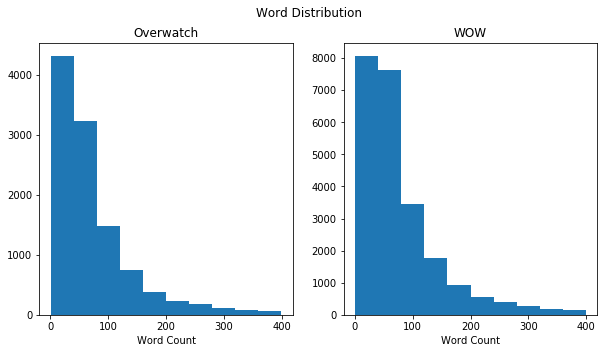

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
fig.suptitle('Word Distribution')
ax1.hist(ow_word_dist[ow_word_dist < 400])
ax2.hist(wow_word_dist[wow_word_dist < 400])
ax1.title.set_text('Overwatch')
ax2.title.set_text('WOW')
ax1.set_xlabel('Word Count')
ax2.set_xlabel('Word Count')

Similar word distributions for both datasets, shown above. Shown below is the character count distribution. The mean number of words and character length are roughly the same across both datasets. Note that this only includes posts that contains self text. 

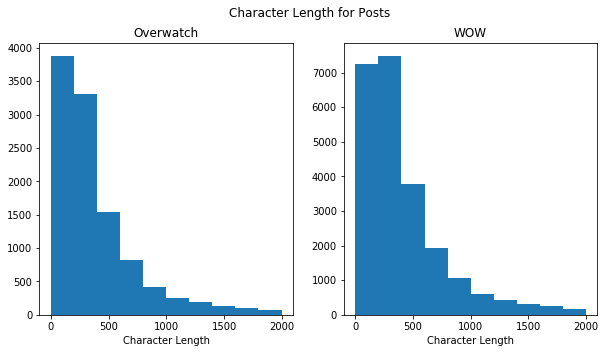

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
fig.suptitle('Character Length for Posts')
ax1.hist(ow_length[ow_length < 2000])
ax2.hist(wow_length[wow_length < 2000])
ax1.title.set_text('Overwatch')
ax2.title.set_text('WOW')
ax1.set_xlabel('Character Length')
ax2.set_xlabel('Character Length');

# Date Conversion

In [12]:
ow['datetime'] = pd.to_datetime(ow['created_utc'], unit = 's').sort_values()
wow['datetime'] = pd.to_datetime(wow['created_utc'], unit = 's').sort_values()

In [13]:
ow['datetime'].sort_values()

19999   2020-04-20 17:54:44
19998   2020-04-20 17:58:05
19997   2020-04-20 17:58:33
19996   2020-04-20 17:59:39
19995   2020-04-20 18:00:22
                ...        
30004   2020-07-17 23:30:16
30003   2020-07-17 23:32:27
30002   2020-07-17 23:33:28
30001   2020-07-17 23:35:24
30000   2020-07-17 23:35:52
Name: datetime, Length: 40000, dtype: datetime64[ns]

Overwatch data extends from April 20th to July 17th. This is about three months of data.

In [14]:
wow['datetime'].sort_values()

19999   2020-03-17 20:16:21
19998   2020-03-17 20:21:17
19997   2020-03-17 20:26:24
19996   2020-03-17 20:31:11
19995   2020-03-17 20:34:32
                ...        
30004   2020-07-21 08:03:05
30003   2020-07-21 08:04:21
30002   2020-07-21 08:04:24
30001   2020-07-21 08:07:31
30000   2020-07-21 08:07:45
Name: datetime, Length: 40000, dtype: datetime64[ns]

WOW data extends from March 17th to July 21st. This is about 4 months of data. While WOW subreddit posts tend to be slightly lengthier and twice as likely to have text than overwatch subreddit posts, the Overwatch subreddit gets posts more often.

# Cleaning and Some EDA

In [15]:
features = ['title', 'selftext', 'datetime', 'subreddit']

In [16]:
#both games are made by a company called blizzard
bliz = pd.concat([ow[features], wow[features]])

In [17]:
#looking for strings less than 10 characters in selftext
bliz[bliz['selftext'].str.len() < 10]['selftext'].value_counts()

[removed]    6978
[deleted]    3470
.              13
Oof            12
Title           5
             ... 
Question.       1
Dire Mall       1
e:)             1
 Weird :D       1
**              1
Name: selftext, Length: 88, dtype: int64

First we'll remove '[removed]' and '[deleted]' from this column and replace with NaN.

In [18]:
bliz.loc[bliz['selftext'] == '[removed]', 'selftext'] = np.nan

In [19]:
bliz.loc[bliz['selftext'] == '[deleted]', 'selftext'] = np.nan

In [20]:
#removes special characters
bliz['title'] = bliz['title'].map(lambda x: re.sub(r'[\.\?\!]', '', x))
bliz.loc[bliz['selftext'].notnull(),'selftext'] = bliz['selftext'].dropna().map(lambda x: re.sub(r'[\.\?\!]', '', x))
bliz.loc[bliz['selftext'].notnull(),'selftext'] = bliz['selftext'].dropna().map(lambda x: re.sub(r'\n', ' ', x))

We can just combine title and selftext into a single column that we'll feed into our model. we'll call this column 'text'.

In [21]:
#copying string from 'title' into 'text' column.
bliz['text'] = bliz['title']
#adding string from 'selftext' into 'text' column.
bliz.loc[bliz['selftext'].notnull(), 'text'] += (' ' + bliz.loc[bliz['selftext'].notnull(), 'selftext'])

We're going to throw out some key words that give away the answer to which subreddit the post comes from. They are 'overwatch', 'ow', and 'warcraft'. We can't throw out 'wow', the acronym for World of Warcraft, since it's also a word.

In [22]:
#lowercase all text
bliz['text'] = bliz['text'].map(lambda x: x.lower())
#replace all instances of the word 'overwatch', 'ow', and 'warcraft'
bliz['text'] = bliz['text'].map(lambda x:re.sub(r'overwatch', '', x))
bliz['text'] = bliz['text'].map(lambda x:re.sub(r'\sow[\s\.]', '', x))
bliz['text'] = bliz['text'].map(lambda x:re.sub(r'warcraft', '', x))

We're going to convert the target categorical variable to a numeric type.

In [23]:
#converting the target variable to 1's and 0's.
bliz['subreddit'] = bliz['subreddit'].map({'Overwatch': 1, 'wow': 0})

In [24]:
X = bliz['text']
y = bliz['subreddit']

Now we'll train-test split the data. After that, we'll instantiate a count vectorizer in order to get a word count for each tokenized word.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    random_state=42)

In [26]:
cvec = CountVectorizer(stop_words = 'english',
                       min_df = 4, 
                       max_df = 0.9, 
                       ngram_range = (1,2))

In [27]:
X_train = cvec.fit_transform(X_train)

In [28]:
X_train_df = pd.DataFrame(X_train.toarray(), columns = cvec.get_feature_names())

Let's take a list at some of the top words in the combined reddit posts.

In [29]:
X_cols = list(X_train_df.columns)

In [30]:
top_words = X_train_df.sum().sort_values(ascending = False).head(15)

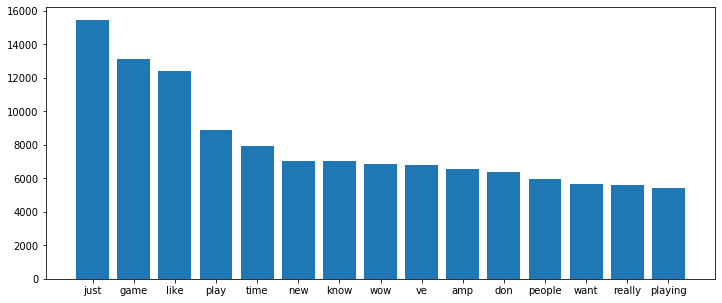

In [31]:
plt.figure(figsize = (12,5))
plt.bar(x=top_words.index, height=top_words);

"ve" and "don" come from contractions like "I've" and "don't". CountVectorizer chose to split these words for some reason.

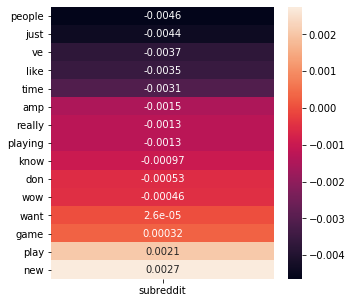

In [32]:
plt.figure(figsize = (5, 5))
word_corr = pd.DataFrame(X_train_df[list(top_words.index)].corrwith(y_train)).rename(columns={0:'subreddit'})
sns.heatmap(word_corr.sort_values('subreddit'), annot = True);

The above figure shows how the appearance of each word correlates to which subreddit it belongs to. This doesn't look like it's very useful. Many of the correlations are very close to zero.

# Fitting a Naive Bayes Model

Now we'll fit a Naive Bayes model to the count vectorized data and classify whether it came from the overwatch or wow subreddit.

In [33]:
nb = MultinomialNB()

In [34]:
nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [35]:
nb.score(X_train, y_train)

0.9352238805970149

In [36]:
X_test = cvec.transform(X_test)

In [37]:
nb.score(X_test, y_test)

0.9215909090909091

The accuracy of the model is fairly good!

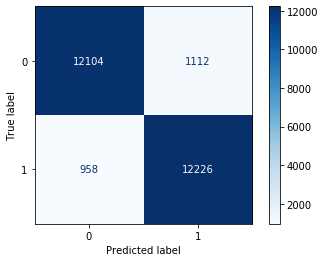

In [38]:
plot_confusion_matrix(nb, X_test, y_test, cmap='Blues', values_format='d');

In [39]:
y_pred = nb.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [40]:
tp/(tp + fn) #sensitivity

0.9273361650485437

In [41]:
tn/(tn + fp) #specificity

0.9158595641646489

Specificity and sensitivity are very close to the accuracy! This tells me that the model is fairly neutral and not biased towards one subreddit over the other.

# Fitting a Random Forest Model

Here, we'll fit a random forest model and do a grid search of the best hyper-parameters.

In [42]:
%%time
rf = RandomForestClassifier(random_state = 42, max_depth = 40)
rf.fit(X_train, y_train)
rf.score(X_train, y_train)

CPU times: user 12.8 s, sys: 176 ms, total: 13 s
Wall time: 14.1 s


0.8504850746268656

In [43]:
rf.score(X_test, y_test)

0.8383712121212121

The random forest classifier takes significantly much longer to run compared to the Naive bayes model and with worst results. This is probably due to the fact that we have too many columns in order for this model to work effectively. The number of features to consider when splitting is $\sqrt{n_{features}}$. We have more than 53,000 columns, meaning that the model has to consider 230 features when splitting! Overall, this model is not effective for the type of data we're analzying. 

# What's the Buzz in the Overwatch Subreddit?

There are currently 32 heroes in overwatch. I would like find out for blizzard which heroes get talked about the most.

In [44]:
heroes = ['ana', 'ashe', 'baptiste', 'bastion', 'brigitte', 'dva', 'doomfist', 'echo', 'genji', 'hanzo',
         'junkrat', 'lucio', 'mccree', 'mei', 'mercy', 'moira', 'orisa', 'pharah', 'reaper', 'reinhardt',
         'roadhog', 'sigma', 'soldier', 'sombra', 'symmetra', 'torbjorn', 'tracer', 'widowmaker', 'winston',
         'ball', 'zarya', 'zenyatta']

Question: How many posts mentions each hero?

We can simply do a search of the hero name in the data. There is a small problem with this because many heroes have nicknames. The dictionary below contains common nicknames for some heroes.

In [45]:
nicknames = {
    'baptiste':'bap',
    'brigitte':'brig',
    'doomfist':'doom',
    'junkrat':'junk',
    'reinhardt':'rein',
    'roadhog':'hog',
    'torbjorn':'torb',
    'widowmaker':'widow',
    'ball':'hammond',
    'zenyatta':'zen'
}

In [46]:
#looking only at overwatch subreddit data from bliz dataframe.
ow_text = bliz[bliz['subreddit'] == 1][['text', 'datetime']]

In [47]:
#This function counts how many posts mentions each hero.
def post_count(df):
    # "mentions" contains the number of posts that mentions that hero.
    mentions = {}
    for hero in heroes:
        mentions[hero] = df[df['text'].str.contains(r'\b'+hero+ r'\b')].shape[0]

        # if the hero has a nickname, search for that nickname and add to the number of mentio
        if hero in nicknames.keys():
            mentions[hero] += df[df['text'].str.contains(r'\b'+nicknames[hero]+ r'\b')].shape[0]

    #sorting the dictionary
    mentions = {k: v for k, v in sorted(mentions.items(), key=lambda item: item[1])}
    return mentions

In [48]:
#sorting the dictionary
mentions = post_count(ow_text)

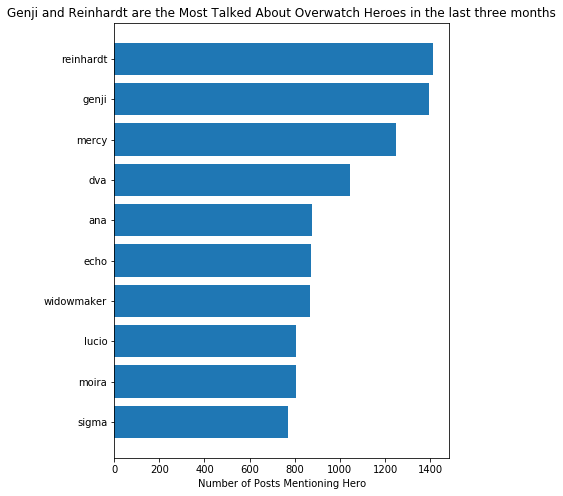

In [49]:
plt.figure(figsize = (6, 8))
plt.xlabel('Number of Posts Mentioning Hero')
plt.barh(y = list(mentions.keys())[-10:], width = list(mentions.values())[-10:])
plt.title('Genji and Reinhardt are the Most Talked About Overwatch Heroes in the last three months');

Genji an Reinhardt have been the most talked about 

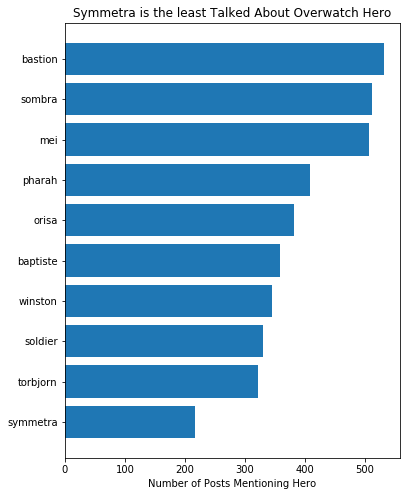

In [50]:
plt.figure(figsize = (6, 8))
plt.xlabel('Number of Posts Mentioning Hero')
plt.barh(y = list(mentions.keys())[:10], width = list(mentions.values())[:10])
plt.title('Symmetra is the least Talked About Overwatch Hero');

We can see that symmetra is the least talked about hero. Perhaps the character isn't very interesting to play or talk about. Let's pull up some dates and look at how things have changed over time.

In [51]:
dates = ow_text['datetime'].sort_values().dt.date.unique()

Let's look at the data across time. Was genji always talked about or is his "popularity" something that happened over time? Below, we're going to look at the number of posts mentioning his name for each day, from June 23 to July 16. We're removing the first and last days since we didn't completely gather all the data from those two days.

In [52]:
# dictionaries for holding the number of posts that mention Genji for each day
ment_gen = {} 
# same as above but for reinhardt
ment_rein = {} 

for day in dates[1:-1]:
    #Search for overwatch posts from a particular day
    text_day = ow_text[ow_text['datetime'].dt.date == day]
    
    #Count number of posts mentioning Genji
    num_post_gen = text_day[text_day['text'].str.contains(r'\bgenji\b')].shape[0] 
    
    #Count number of posts mentioning Reinhardt
    num_post_rein = text_day[text_day['text'].str.contains(r'rein')].shape[0] 
    
    #appending results to dictionary
    ment_gen[day] = num_post_gen
    ment_rein[day] = num_post_rein

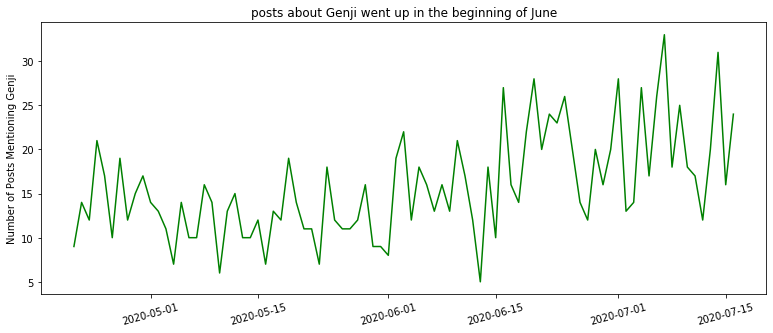

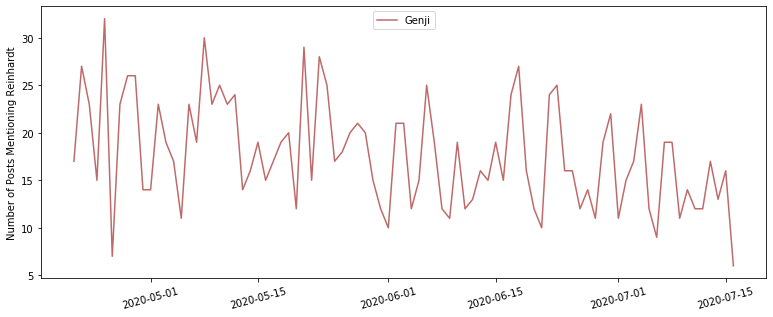

In [53]:
#plots time data for Genji
plt.figure(figsize = (13, 5))
ax = sns.lineplot(x=list(ment_gen.keys()),y=list(ment_gen.values()), color = 'green')
plt.xticks(rotation=15)
plt.ylabel('Number of Posts Mentioning Genji')
plt.title('posts about Genji went up in the beginning of June')

#plots time data for Reinhardt
plt.figure(figsize = (13, 5))
ax = sns.lineplot(x=list(ment_rein.keys()),y=list(ment_rein.values()), color = 'brown', alpha = 0.7)
plt.xticks(rotation=15)
plt.ylabel('Number of Posts Mentioning Reinhardt')

ax.legend(labels = ['Genji', 'Reinhardt'], loc = 'upper center')
plt.show()


We can see from the plot above that there is a jump in "chatter" about Genji going from May to June. Let's compare data for May and for June.

In [54]:
#creating an additional column for month
ow_text['month'] = ow_text['datetime'].dt.date.map(lambda x:x.month)

In [55]:
may = ow_text[ow_text['month'] == 5]
jun = ow_text[ow_text['month'] == 6]

In [56]:
may_mentions = post_count(may)
jun_mentions = post_count(jun)

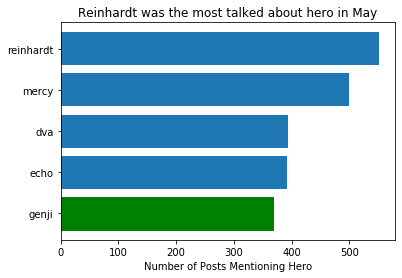

In [57]:
plt.figure(figsize = (6, 4))
plt.xlabel('Number of Posts Mentioning Hero')
barlist = plt.barh(y = list(may_mentions.keys())[-5:], width = list(may_mentions.values())[-5:])
barlist[0].set_color('g')
plt.title('Reinhardt was the most talked about hero in May');

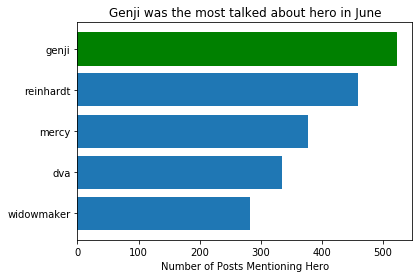

In [58]:
plt.figure(figsize = (6, 4))
plt.xlabel('Number of Posts Mentioning Hero')
barlist = plt.barh(y = list(jun_mentions.keys())[-5:], width = list(jun_mentions.values())[-5:])
barlist[4].set_color('g')
plt.title('Genji was the most talked about hero in June');

Doing some research online, we can see that Genji recieved some buffs on June 2nd in the experimental mode. A link can be found here: https://dotesports.com/overwatch/news/overwatchs-newest-experimental-card-tests-genji-changes. A buff is when the developer decides to make a character stronger. The experimental mode in Overwatch let's players test out possible changes to the game that may or may not go live at a later date. On June 15th, the buffs to Genji went live (https://dotesports.com/overwatch/news/priority-queue-genji-buffs-added-in-overwatchs-latest-live-patch).

# Sentiment Analysis

Let's look at text that both the word "Genji" and "nerf".

In [59]:
is_genji = ow_text['text'].str.contains(r'\bgenji\b')
is_nerf = ow_text['text'].str.contains(r'\bnerf\b')
genji_nerf = ow_text[is_genji & is_nerf][['text', 'month']]
print('Number of posts that contain "genji", and "nerf":',genji_nerf.shape[0])

Number of posts that contain "genji", and "nerf": 34


I've looked for all posts containing the words "genji" and "nerf". The word "nerf" is the opposite of "buff". Judging from player feedback, there is a vocal group of players who want nerf Genji or reverse some of the changes. Note that all of these posts occurred in the month of June. 

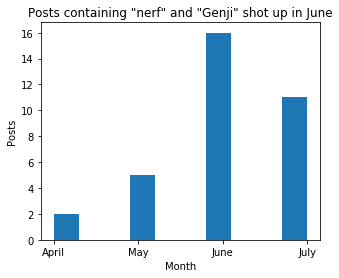

In [60]:
plt.figure(figsize= (5, 4))
plt.hist(genji_nerf['month'])
plt.xlabel('Month')
plt.xticks(ticks = [4,5,6,7], labels = ['April', 'May', 'June', 'July'])
plt.ylabel('Posts')
plt.title('Posts containing "nerf" and "Genji" shot up in June');

There is an increase in the number of calls by the player base for Genji to be nerfed. In order to keep the game healthy, I'd recommend that blizzard nerf Genji slightly or revert some of the buffs that they made in early June. 